In [2]:
import numpy as np
from voxcell import VoxelData
from voxcell.nexus.voxelbrain import Atlas
from utils import *
import morphio
import neurom as nm

In [2]:
morphio.version

'3.3.4'

In [99]:
!pip list | grep 'neurom'

neurom                        3.2.2

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
atlas_dir = '25um/'
hierarchy_path = '25um/hierarchy.json'

In [4]:
atlas = Atlas.open(atlas_dir)

In [5]:
region_map = atlas.load_region_map()

In [6]:
mask = atlas.get_region_mask('CA1')

In [7]:
vd = VoxelData.load_nrrd(f'{atlas_dir}/brain_regions.nrrd')

In [8]:
mask.raw.shape

(528, 320, 456)

In [9]:
#mask.indices_to_positions([1,2,3])
#mask.positions_to_indices([123.2,1442.4,624.5])

In [10]:
sample_morph = 'swc30/AA0998.swc'

In [11]:
morph = morphio.Morphology(sample_morph)
m = nm.load_morphology(sample_morph)
m_axon = m.neurites[0] # for this morph only

In [13]:
from voxcell.math_utils import voxel_intersection

In [20]:
mask.raw.shape

(528, 320, 456)

In [22]:
mask

In [21]:
mask = atlas.get_region_mask('CA1')
voxel_intersection(m_axon.points[:,:3],mask)

AttributeError: 'numpy.ndarray' object has no attribute 'bbox'

In [12]:
# filter morph based on region
target_roi = 'CA1' # get axon tree residing in CA1
target_roi_mask = atlas.get_region_mask(target_roi)
#convert morph_positions to atlas indices for axons
morph_indices = mask.positions_to_indices(morph.points)


In [38]:
axon_sections = [i for i in morph.sections if i.type.name == 'axon']
len(axon_sections)

523

In [45]:
morphio_positions_axon = 0
for i in range(len(axon_sections)):
    morphio_positions_axon += axon_sections[i].points.shape[0]
morphio_positions_axon

8430

In [42]:
m.neurites[0].points.shape

(7908, 4)

In [48]:
new_morph = morphio.mut.Morphology()
new_morph.append_root_section(morph.points[0], morph.points[1], morphio.)

Docstring:
append_root_section(*args, **kwargs)
Overloaded function.

1. append_root_section(self: morphio._morphio.mut.Morphology, point_level_properties: morphio._morphio.PointLevel, section_type: morphio._morphio.SectionType) -> morphio::mut::Section

Append a root Section


2. append_root_section(self: morphio._morphio.mut.Morphology, immutable_section: morphio._morphio.Section, recursive: bool = False) -> morphio::mut::Section

Append the existing immutable Section as a root section
If recursive == true, all descendent will be appended as well

3. append_root_section(self: morphio._morphio.mut.Morphology, mutable_section: morphio::mut::Section, recursive: bool = False) -> morphio::mut::Section

Append the existing mutable Section as a root section
If recursive == true, all descendent will be appended as well
Type:      method

In [31]:
m_axon.points.shape

(7908, 4)

In [23]:
axon_indices = mask.positions_to_indices(axon_section.points)

In [26]:
axon_section.children

In [11]:
# examplar filtering based on X. Will be converted to brain regions
from neurom import COLS

in_mask = []
for sec in morph.sections:
    if (sec.points[COLS.X] > 300).any():  # Note that you can use .all() instead of .any() if you only want the sections entirely contained in the mask
        in_mask.append(sec)

In [12]:
len(in_mask)

551

In [13]:
in_mask[0].points

array([[6837.023 , 2410.6694, 6785.5864],
       [6821.672 , 2405.289 , 6808.6094],
       [6808.783 , 2417.5742, 6807.1406],
       [6791.1914, 2437.586 , 6794.0854]], dtype=float32)

In [14]:
mask.positions_to_indices(in_mask[0].points)

array([[273,  96, 271],
       [272,  96, 272],
       [272,  96, 272],
       [271,  97, 271]])

In [15]:
#from voxcell import RegionMap
#region_map = RegionMap.load_json(f'{atlas_dir}/hierarchy.json')
# # Or you can instantiate directly from a nested directory :
# region_map = RegionMap.from_dict(hierarchy_dict)

In [16]:
#get region mask from indices
#np.unique(vd.raw)
#vd.raw[273,96,271]

In [17]:
region_map.get(vd.raw[273,96,271], "name") # i.e. 632th annotation

'Dentate gyrus, granule cell layer'

In [18]:
mask.positions_to_indices(in_mask[0].points)[0]

array([273,  96, 271])

In [19]:
region_ids = idxs_to_voxel_ids(vd,mask.positions_to_indices(in_mask[0].points))
region_ids

[632, 632, 632, 632]

In [20]:
voxel_ids_to_region_names(region_map,region_ids)

['Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer']

In [21]:
# get region id of each section

mult_region_mask = [] # we expect these in cases to transition from and to WM. But also due to registration issues to average atlas.
efferent_regions = []
for sec in morph.sections:
    voxel_ids = idxs_to_voxel_ids(vd,mask.positions_to_indices(sec.points))
    if len(np.unique(voxel_ids)) > 1:
        #print(f"more than one region in this section. Regions: {len(np.unique(voxel_ids))}")
        mult_region_mask.append(sec)
    cur_regions = voxel_ids_to_region_names(region_map,voxel_ids)
    if len(np.unique(cur_regions)) == 1:
        efferent_regions.append(cur_regions[0])
        continue
    else:
        efferent_regions.append(np.unique(voxel_ids_to_region_names(region_map,voxel_ids),return_counts=True))
    #print(voxel_ids)

In [25]:
efferent_regions

['Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus, granule cell layer',
 (array(['Dentate gyrus, granule cell layer',
         'Dentate gyrus, polymorph layer'], dtype='<U33'),
  array([23,  6])),
 (array(['Dentate gyrus, granule cell layer',
         'Dentate gyrus, molecular layer'], dtype='<U33'),
  array([1, 1])),
 'Dentate gyrus, molecular layer',
 'Dentate gyrus, molecular layer',
 'Dentate gyrus, molecular layer',
 (array(['Dentate gyrus, molecular layer', 'Subiculum'], dtype='<U30'),
  array([24,  2])),
 'Dentate gyrus, molecular layer',
 (array(['Dentate gyrus, granule cell layer',
         'Dentate gyrus, molecular layer'], dtype='<U33'),
  array([1, 7])),
 'Dentate gyrus, molecular layer',
 'Dentate gyrus, molecular layer',
 'Dentate gyrus, molecular layer',
 (array(['Dentate gyrus, granule cell layer',
         'Dentate 

In [ ]:
neurom.graft_morphology??

In [22]:
for sec in morph.sections:
    print(sec.type)
    assert sec.type == morphio._morphio.SectionType.axon
    break

SectionType.axon


In [23]:
sections = []
for section in morph.iter():
    if section.type.name == 'axon':
        sections.append(len(section.points))

In [24]:
np.max(sections)

76

In [25]:
[i.type.name for i in morph.root_sections]

['axon',
 'basal_dendrite',
 'basal_dendrite',
 'basal_dendrite',
 'basal_dendrite',
 'basal_dendrite',
 'basal_dendrite']

In [67]:
axon_sec_pos = [i.points for i in morph.sections if i.type.name=='axon']
axon_sec_pos = np.concatenate(axon_sec_pos).tolist()
# Reshape the list into a NumPy array with shape (n, 3)
coords = np.reshape(axon_sec_pos, (-1, 3))

# Extract the x, y, and z coordinates from the NumPy array
x = coords[:, 0]
y = coords[:, 1]
z = coords[:, 2]

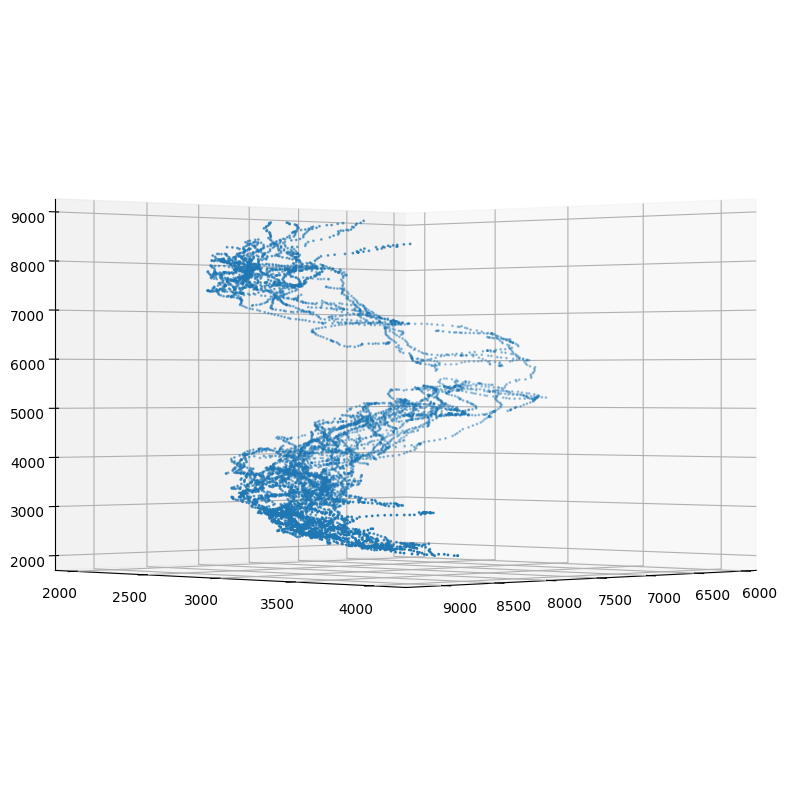

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot of the section
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, 'k',1)
ax.view_init(elev=0, azim=45)
plt.show()

In [59]:
import voxcell
import matplotlib.pyplot as plt

In [60]:
coords.shape

(8430, 3)

In [29]:
def positions_to_allen_ids(voxeldata: voxcell.voxel_data.VoxelData,
                           positions:np.array):
    '''
    From any positions, get allen ids corresponding to that position
    mask: atlas.get_region_mask object to perform positions_to_indices method
    voxeldata : loaded brain_regions.nrrd in voxcell
    positions : Nx3 positions array
    '''
    indices = voxeldata.positions_to_indices(positions).tolist()
    id_list = []
    for idx,idy,idz in indices:
        id_list.append(voxeldata.raw[idx,idy,idz])
    return id_list

/nvme/kurban/1491298/ipykernel_257334/1865718960.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[mask], y[mask], z[mask], c=colors[i], marker='o', label=f"{region_map.get(idd,'acronym')}")


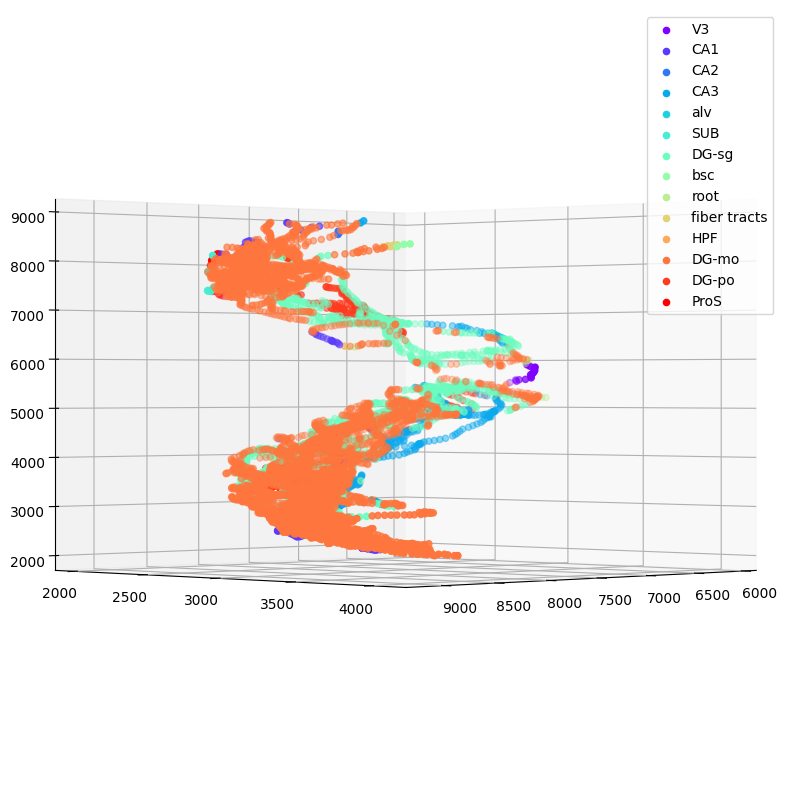

In [64]:
ids = positions_to_allen_ids(vd,coords)
# Get the unique IDs and corresponding colors
unique_ids = np.unique(ids)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_ids)))

# Create a 3D plot and plot the points with different colors
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i, idd in enumerate(unique_ids):
    mask = ids == idd
    ax.scatter(x[mask], y[mask], z[mask], c=colors[i], marker='o', label=f"{region_map.get(idd,'acronym')}")
ax.view_init(elev=0, azim=45)
ax.legend()

plt.show()

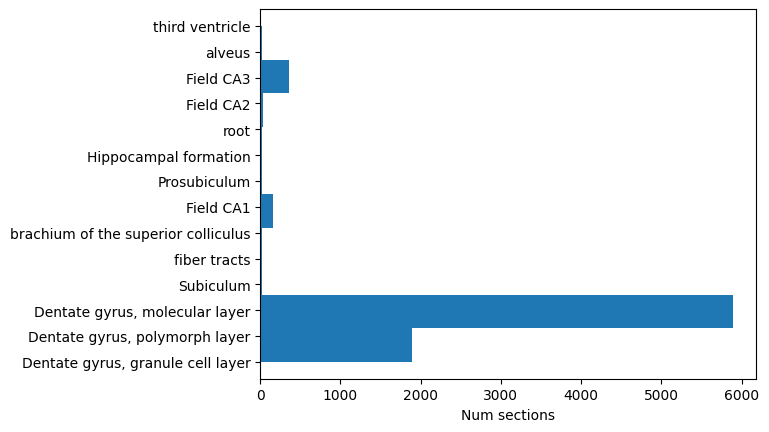

In [33]:
fig, ax = plt.subplots()
ax.hist(voxel_ids_to_region_names(region_map,ids),orientation='horizontal')
plt.xlabel('Num sections')
# Rotate the x-axis label 45 degrees
#plt.xticks(rotation=90)

plt.show()

In [34]:
from neurom import viewer
import neurom as nm

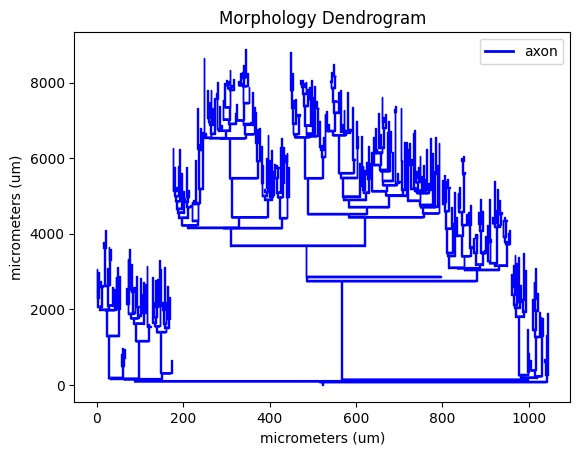

In [35]:
fig, ax = viewer.draw(m.neurites[0], mode='dendrogram') 

# get a pandas df from swc file positions

In [36]:
def read_swc(filename):
    """
    Read an SWC file and return the segments as a list of dictionaries.
    """
    segments = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split()
            segment = {
                'id': int(fields[0]),
                'type': int(fields[1]),
                'x': float(fields[2]),
                'y': float(fields[3]),
                'z': float(fields[4]),
                'radius': float(fields[5]),
                'parent': int(fields[6]) - 1  # SWC parent ID is 1-based
            }
            segments.append(segment)
    return segments

In [41]:
segments = read_swc(sample_morph)

In [107]:
len(segments)

8017

In [38]:
import pandas as pd

In [39]:
def positions_to_allen_ids_wrapper(row):
    positions = np.array([row['x'], row['y'], row['z']])
    return positions_to_allen_ids(vd, positions)

In [72]:
df = pd.DataFrame(segments)
df_axon = df[df.type==2]
df_axon

,id,type,x,y,z,radius,parent
1,2,2,6837.022782,2410.669455,6785.586277,1.0,0
2,3,2,6821.671951,2405.289070,6808.609591,1.0,1
3,4,2,6808.783000,2417.574157,6807.140703,1.0,2
4,5,2,6791.191392,2437.585943,6794.085651,1.0,3
5,6,2,6782.624958,2454.602686,6791.437749,1.0,4
...,...,...,...,...,...,...,...
7904,7905,2,7268.886634,2669.487385,6337.742266,1.0,7903
7905,7906,2,7250.496262,2672.816435,6341.070458,1.0,7904
7906,7907,2,7242.925853,2662.782306,6360.422123,1.0,7905
7907,7908,2,7224.820429,2657.512790,6358.968795,1.0,7906


In [73]:
len(df[df.type==2])

7908

In [80]:
coords

array([[6837.02294922, 2410.66943359, 6785.58642578],
       [6821.671875  , 2405.2890625 , 6808.609375  ],
       [6808.78320312, 2417.57421875, 6807.140625  ],
       ...,
       [7242.92578125, 2662.78222656, 6360.42236328],
       [7224.8203125 , 2657.51269531, 6358.96875   ],
       [7215.03515625, 2658.87304688, 6363.0234375 ]])

In [ ]:
!cat

In [76]:
xyz = np.array([df_axon.x,df_axon.y,df_axon.z])
xyz = np.reshape(xyz, (-1, 3))

xyz

array([[6837.022782, 6821.671951, 6808.783   ],
       [6791.191392, 6782.624958, 6786.800992],
       [6812.863126, 6822.562611, 6833.406256],
       ...,
       [6331.523554, 6340.757679, 6337.250038],
       [6328.960788, 6337.742266, 6341.070458],
       [6360.422123, 6358.968795, 6363.023467]])

In [78]:
xyz.shape

(7908, 3)

In [102]:
morph.points.shape

(8561, 3)

In [105]:
m.points.shape

(8561, 4)

In [101]:
axon_sec_pos = [i.points for i in morph.sections if i.type.name=='axon']
axon_sec_pos = np.concatenate(axon_sec_pos).tolist()
# Reshape the list into a NumPy array with shape (n, 3)
coords = np.reshape(axon_sec_pos, (-1, 3))
coords.shape

(8430, 3)

In [109]:
!head swc30/AA0998.swc

# Please consult Terms-of-Use at https://mouselight.janelia.org when referencing this reconstruction.
# DOI:					10.25378/janelia.7821962
# Neuron Id:			AA0998
# Sample Date:			Wed, 01 Aug 2018 17:24:59 GMT
# Sample Strain:		Sim1-Cre
# Label Virus:			PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo
# Label Fluorophore:		Immunolabeled with anti-GFP, Alexa-488
# Annotation Space:		CCFv3.0             Axes> X: Anterior-Posterior; Y: Inferior-Superior; Z:Left-Right
1	1	6837.022782	2411.582703	6786.482555	1.000000	-1
2	2	6837.022782	2410.669455	6785.586277	1.000000	1


In [110]:
!tail swc30/AA0998.swc

8008	3	6951.017594	2510.056632	6801.116998	1.000000	8007
8009	3	6957.539029	2525.245948	6806.953041	1.000000	8008
8010	3	6925.263752	2502.071243	6795.210707	1.000000	8006
8011	3	6924.081885	2505.627888	6795.929799	1.000000	8010
8012	3	6912.566517	2521.077253	6812.413914	1.000000	8011
8013	3	6899.195099	2543.791052	6828.296645	1.000000	8012
8014	3	6889.158320	2550.169792	6845.046866	1.000000	8013
8015	3	6884.248125	2555.835870	6853.008015	1.000000	8014
8016	3	6934.302943	2505.046997	6800.976515	1.000000	8011
8017	3	6939.316639	2516.042823	6804.163857	1.000000	8016


In [ ]:
from utils import get_children
import json

In [ ]:
selected_id = 8
child_ids = get_children(hierarchy_path, atlas_id=selected_id)
print({selected_id:child_ids})
print({voxel_ids_to_region_names(selected_id):voxel_ids_to_region_names(child_ids)})

In [ ]:
wm_root_acronym = 'fiber tracts'
wm_region_ids = get_children2(hierarchy_path,acronym=wm_root_acronym)

In [ ]:
voxel_ids_to_region_names(wm_region_ids)

In [ ]:
with open(hierarchy_path, "r") as f:
    hierarchy = json.load(f)
        
msg = hierarchy["msg"][0]

In [ ]:
len(hierarchy["msg"])

In [ ]:
msg = hierarchy['msg'][0]